In [33]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('../utils')
import operator_calculations as op_calc
import stats
from sklearn.linear_model import LinearRegression
import delay_embedding as embed
import clustering_methods as cl
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [35]:
def alpha_x(v):
    """Implement the alpha."""  # = \theta (\mu-Y_t)
    return v

def alpha_v(x,v,gamma,m):
    """Implement the alpha."""  # = \theta (\mu-Y_t)
    return -(gamma/m)*v - (4/m)*x*(x**2-1)

def beta(sigma):
    """Implement the  beta."""  # = \sigma
    return sigma

def dW(delta_t):
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def euler_maruyama(y0,ts,dt,sigma,gamma,m):
    ys = np.zeros((len(ts),2))
    ys[0] = y0
    for i in range(1,len(ts)):
        t = (i-1)*dt
        x = ys[i-1,0]
        v = ys[i-1,1]
        ys[i,0] = x + alpha_x(v)*dt
        ys[i,1] = v + alpha_v(x,v,gamma,m)*dt + beta(sigma)*dW(dt)
    return ys

In [38]:
k_b_T = 1.0
gamma = 1
m=1
T = 100000

integration_step = 1e-2
sigma = np.sqrt(2*gamma*k_b_T)/m
x0 = np.random.uniform(-1,1,2)
discard_t = 500

dt = .1
sampling_time = int(dt/integration_step) 

T_total = T+discard_t
ts = np.arange(0, T_total, integration_step)
tseries = euler_maruyama(x0,ts,integration_step,sigma,gamma,m)[int(discard_t/integration_step):][::sampling_time]
ts = ts[:-int(discard_t/integration_step)][::sampling_time]

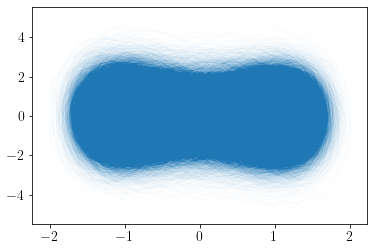

In [40]:
plt.plot(tseries[:,0],tseries[:,1],lw=.01)
plt.show()

# Compute predictability as a function of delay

In [41]:
X = tseries[:,0].reshape((tseries.shape[0],1)) #take x variable only

In [42]:
#to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seed_range=np.array(np.logspace(1,3,4),dtype=int) #number of partitions to examine
range_Ks =  np.arange(1,8,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(n_seed_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X),K=K-1)
    for ks,n_seeds in enumerate(n_seed_range):
        labels=cl.kmeans_knn_partition(traj_matrix,n_seeds)
        h = op_calc.get_entropy(labels)
        h_K[k,ks]=h
        print('Computed for {} delays and {} seeds.'.format(K,n_seeds))

Computed for 1 delays and 10 seeds.
Computed for 1 delays and 46 seeds.
Computed for 1 delays and 215 seeds.
Computed for 1 delays and 1000 seeds.
Computed for 2 delays and 10 seeds.
Computed for 2 delays and 46 seeds.
Computed for 2 delays and 215 seeds.
Computed for 2 delays and 1000 seeds.
Computed for 3 delays and 10 seeds.
Computed for 3 delays and 46 seeds.
Computed for 3 delays and 215 seeds.
Computed for 3 delays and 1000 seeds.
Computed for 4 delays and 10 seeds.
Computed for 4 delays and 46 seeds.
Computed for 4 delays and 215 seeds.
Computed for 4 delays and 1000 seeds.
Computed for 5 delays and 10 seeds.
Computed for 5 delays and 46 seeds.
Computed for 5 delays and 215 seeds.
Computed for 5 delays and 1000 seeds.
Computed for 6 delays and 10 seeds.
Computed for 6 delays and 46 seeds.
Computed for 6 delays and 215 seeds.
Computed for 6 delays and 1000 seeds.
Computed for 7 delays and 10 seeds.
Computed for 7 delays and 46 seeds.
Computed for 7 delays and 215 seeds.
Computed 

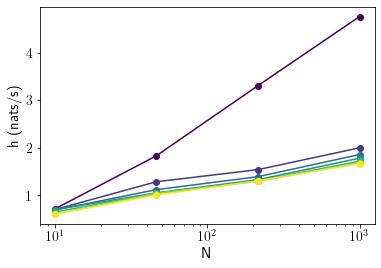

In [43]:
colors_K = plt.cm.viridis(np.linspace(0,1,len(range_Ks)))
for k,K in enumerate(range_Ks):
    plt.plot(n_seed_range,h_K[k],c=colors_K[k],marker='o')
plt.xlabel('N',fontsize=15)
plt.ylabel('h (nats/s)',fontsize=15)
plt.xscale('log')
plt.show()

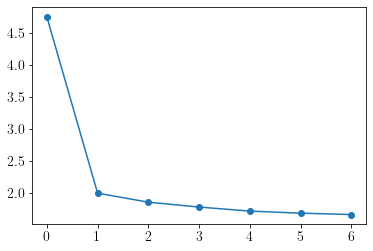

In [44]:
plt.plot(h_K[:,-1],marker='o')
plt.show()

In [45]:
K_star=7
traj_matrix = embed.trajectory_matrix(X,K=K_star-1)

# Estimate implied time scales of the reversibilized operator

In [46]:
#to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seeds = 1000
n_modes=10

labels = ma.array(cl.kmeans_knn_partition(traj_matrix,n_seeds),dtype=int)

delay_range = np.arange(5,101,5)
n_modes=5
ts_traj = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
    P = op_calc.transition_matrix(labels,delay)
    R = op_calc.get_reversible_transition_matrix(P)
    ts_traj[kd,:] = op_calc.compute_tscales(R,delay,dt,k=n_modes+1)
    print(delay)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


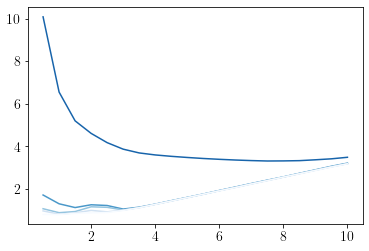

In [47]:
colors_modes = plt.cm.Blues_r(np.linspace(0.2,1,n_modes))
for km in range(n_modes):
    plt.plot(delay_range*dt,ts_traj[:,km],c=colors_modes[km])
plt.show()

In [48]:
delay = int(5/dt)
print(delay*dt)
P = op_calc.transition_matrix(labels,delay)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=3)
print(eigvals)

5.0
[1.        +0.j 0.23811489+0.j 0.0447294 +0.j]


In [54]:
phi2=eigvecs[labels,1].real

In [50]:
u,s,v = np.linalg.svd(traj_matrix,full_matrices=False)

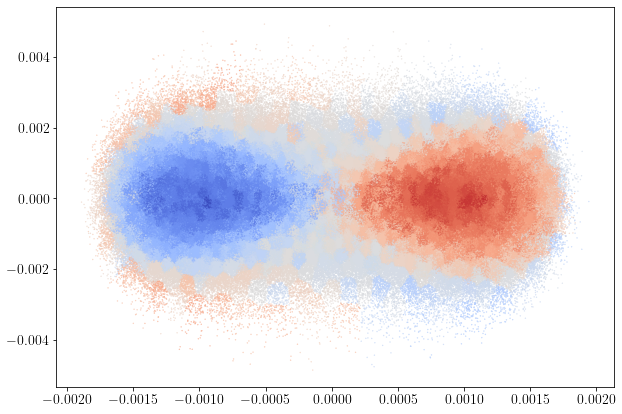

In [57]:
plt.figure(figsize=(10,7))
color_abs = np.max(np.abs(phi2))
plt.scatter(u[:,0],u[:,1],c=phi2,cmap='coolwarm',s=.1,vmin=-color_abs,vmax=color_abs)
plt.show()